
# Ultimate Challange 



1. [Part 1 - Exploratory Data Analysis](#part1)
    1. [Introduction](#introduction)
    2. [Summary](#summary)
2. [Part 2 - Experiment and Metrics Design](#part2)
    1. [Solution](#solution)
3. [Part 3 - Predictive Modeling](#part3)
    1. [Introduction](#intro)
    2. [Data Wrangling](#wrangle)
    3. [EDA](#eda)
    4. [Modeling](#model)
        1. [Additional Preprocessing](#process)
        2. [Initial Model](#initial)
        3. [Hyperparameter Tuning](#tuning)
        4. [Summary and Recommendations](#recommend)


# Part 1 - Exploratory data analysis<a name="part1">

## Introduction <a name="introduction">

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [1]:
#import libraries
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
#load data
with open("logins.json","r") as file:
    logins = json.load(file)

In [3]:
#create a dataframe
logins_df = pd.DataFrame.from_dict(logins)

In [4]:
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [5]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   login_time  93142 non-null  object
dtypes: object(1)
memory usage: 727.8+ KB


In [6]:
#convert data to a datetime object
logins_df['login_time'] = pd.to_datetime(logins_df['login_time'])

In [7]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [8]:
#add a column of ones to represent a single log in at that time
logins_df['num_logins'] = 1

In [9]:
#group into 15 minute intervals and sum the logins 
logins_df_agg = logins_df.groupby([pd.Grouper(key='login_time', freq='15min')]).sum()

In [10]:
logins_df_agg.head()

,num_logins
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


(array([  0.,  14.,  31.,  45.,  59.,  73.,  90., 104.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

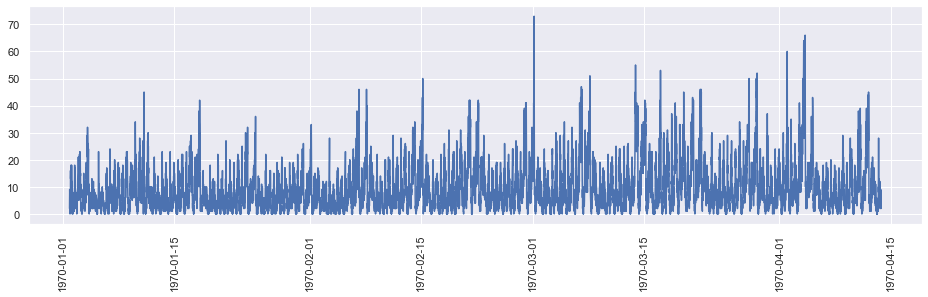

In [11]:
sns.set()
fig, ax = plt.subplots(1,1)
fig.set_size_inches(16, 4)
plt.plot(logins_df_agg)
plt.xticks(rotation=90)

**There is an obvious cyclical pattern. Let's take a closer look at some subsets**

(array([31., 35., 39., 43., 47., 51., 55., 59.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

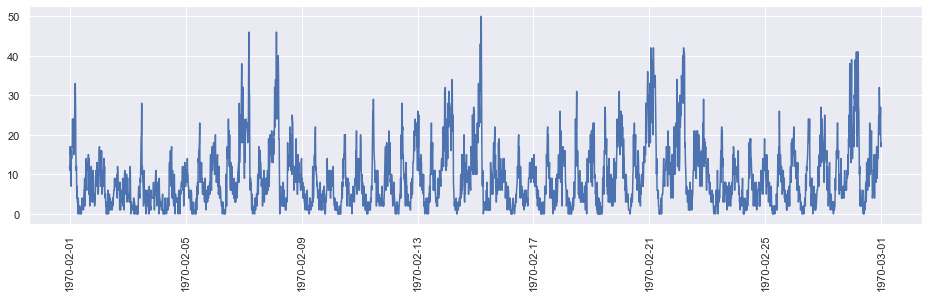

In [12]:
#display the month of February
fig, ax = plt.subplots(1,1)
fig.set_size_inches(16, 4)
plt.plot(logins_df_agg.loc['1970-02-01':'1970-02-28'])
plt.xticks(rotation=90)

In [13]:
#This date is a Sunday
pd.to_datetime('1970-02-01').dayofweek

6

In [14]:
February = logins_df_agg.loc['1970-02-01':'1970-02-28']
February_weekend = February[February.index.dayofweek > 4]
February_weekday = February[February.index.dayofweek < 5]

In [15]:
feb_weekend_mean = February_weekend['num_logins'].mean()
feb_weekday_mean = February_weekday['num_logins'].mean()

In [16]:
print("Average weekend logins in Feruary is: {:.1f}".format(feb_weekend_mean))
print("Average weekday logins in Feruary is: {:.1f}".format(feb_weekday_mean))
print("The weekend demand is {:.1f}% higher than the weekday demand".format((feb_weekend_mean / feb_weekday_mean - 1)*100))

Average weekend logins in Feruary is: 12.8
Average weekday logins in Feruary is: 7.7
The weekend demand is 66.2% higher than the weekday demand


**Looking at just the month of February, there is a 66% increase in demand over the weekend**

(array([4. , 4.5, 5. , 5.5, 6. , 6.5, 7. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

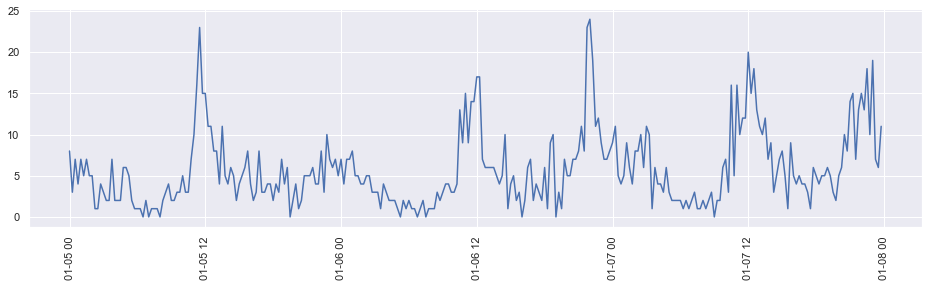

In [17]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(16, 4)
plt.plot(logins_df_agg.loc['1970-01-05':'1970-01-07'])
plt.xticks(rotation=90)



**Looking at a three day subsample, it is clearer that there is a peak in demand every twelve hours at noon and midnight.**


### Summary <a name = "summary">

The data shows nested patterns. Weekly, demand spikes over the weekend and daily, demand spikes at noon and midnight. There may be yearly patterns but more data will be required


# Part 2 - Experiment and metrics design <a name="part2">

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.


1) **What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?**


2) **Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:**
    
    a) how you will implement the experiment
    
    b) what statistical test(s) you will conduct to verify the significance of the observation
    
    c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.



## Solution <a name="solution">

1) Because the driver partners would still have to pass through the toll booths, data on the number of trips could be collected. The mean number of passes through the tolls in a given time span could be the key metric to describe any change. The mean is ideal because it is scalable and can be easily calculated for particular time spans, i.e. weeks to months and weekdays versus weekends.

    1) a) If the idea is to make the driver partners serve both cities, it would be important that the public is notified of this change as well as the driver partners. This way, the public knows they can use either company at anytime. Data would have to be collected at toll booths. Drivers would need a special ID or their vehicle equipped with a transponder to monitor their passage.
       
       b) Several statistical tests could be employed to verify changes in driver partner trips. Analysis of varience would help to confirm any difference in group means between one company and another, one time frame and another, and/or before and after the experiment. Also, regression analysis would be appropriate as the number of trips will likely increase over time.
       
       c) If the experiment showed no significant change in movement of driver partners then it would be recommended to discontinue the experiment and seek alternative possibilites. However, if there was significant increase in movement it would be advised to continue with the promotion; at least for the time being. Some boundary of mean trips would need to be set and data would need to be continualy collected to assure that the driver partners do not revert to serving only one city. There is a cost to maintaining this data collection and lost revenue from the tolls.


# Part 3 - Predictive Modeling <a name="part3">


## Introduction <a name="intro">
    
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.


## Data wrangling <a name='wrangle'>

In [18]:
#load data
with open("ultimate_data_challenge.json","r") as file:
    udc = json.load(file)

In [19]:
udc_df = pd.DataFrame(udc)

In [20]:
#examine the data and summary statistics
udc_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [21]:
udc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [22]:
udc_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [23]:
#change sign_up_date and last_trip_date to DateTime objects
udc_df["signup_date"] = pd.to_datetime(udc_df["signup_date"])
udc_df["last_trip_date"] = pd.to_datetime(udc_df["last_trip_date"])

In [24]:
udc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [25]:
#deal with missing data in the avg_rating_of_driver column
udc_df['avg_rating_of_driver'].isnull().sum() 

8122

In [26]:
#impute the missing avg_ratings_of_drivers with the mean
udc_df['avg_rating_of_driver'] = udc_df['avg_rating_of_driver'].fillna(udc_df['avg_rating_of_driver'].mean())

In [27]:
udc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [28]:
#drop rows with missing phone type
udc_df.dropna(inplace = True)

In [29]:
udc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49406 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49406 non-null  object        
 1   trips_in_first_30_days  49406 non-null  int64         
 2   signup_date             49406 non-null  datetime64[ns]
 3   avg_rating_of_driver    49406 non-null  float64       
 4   avg_surge               49406 non-null  float64       
 5   last_trip_date          49406 non-null  datetime64[ns]
 6   phone                   49406 non-null  object        
 7   surge_pct               49406 non-null  float64       
 8   ultimate_black_user     49406 non-null  bool          
 9   weekday_pct             49406 non-null  float64       
 10  avg_dist                49406 non-null  float64       
 11  avg_rating_by_driver    49406 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [30]:
#encode the categorical data
dummy_city = pd.get_dummies(udc_df['city'], prefix='city_')
dummy_phone = pd.get_dummies(udc_df['phone'], prefix='phone_')

In [31]:
#estimate when the data was collected
recent_date = udc_df['last_trip_date'].max()

In [32]:
udc_df['active'] = ((recent_date - udc_df['last_trip_date']) <= '30 days')

In [33]:
udc_df = udc_df.astype({'ultimate_black_user': 'uint8', 'active': 'uint8'})

In [34]:
#build the final dataframe used for modeling
df = pd.merge(left=udc_df, right=dummy_city,left_index=True, right_index=True,)
df = pd.merge(left=df, right=dummy_phone,left_index=True, right_index=True,)
df.drop(['city', 'phone', 'signup_date', 'last_trip_date'], axis=1, inplace=True)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49406 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  49406 non-null  int64  
 1   avg_rating_of_driver    49406 non-null  float64
 2   avg_surge               49406 non-null  float64
 3   surge_pct               49406 non-null  float64
 4   ultimate_black_user     49406 non-null  uint8  
 5   weekday_pct             49406 non-null  float64
 6   avg_dist                49406 non-null  float64
 7   avg_rating_by_driver    49406 non-null  float64
 8   active                  49406 non-null  uint8  
 9   city__Astapor           49406 non-null  uint8  
 10  city__King's Landing    49406 non-null  uint8  
 11  city__Winterfell        49406 non-null  uint8  
 12  phone__Android          49406 non-null  uint8  
 13  phone__iPhone           49406 non-null  uint8  
dtypes: float64(6), int64(1), uint8(7)
memo


## EDA <a name='eda'>

In [36]:
udc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49406 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49406 non-null  object        
 1   trips_in_first_30_days  49406 non-null  int64         
 2   signup_date             49406 non-null  datetime64[ns]
 3   avg_rating_of_driver    49406 non-null  float64       
 4   avg_surge               49406 non-null  float64       
 5   last_trip_date          49406 non-null  datetime64[ns]
 6   phone                   49406 non-null  object        
 7   surge_pct               49406 non-null  float64       
 8   ultimate_black_user     49406 non-null  uint8         
 9   weekday_pct             49406 non-null  float64       
 10  avg_dist                49406 non-null  float64       
 11  avg_rating_by_driver    49406 non-null  float64       
 12  active                  49406 non-null  uint8 

In [37]:
udc_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
count,49406.000000,49406.000000,49406.000000,49406.000000,49406.000000,49406.000000,49406.000000,49406.000000,49406.000000
mean,2.284176,4.601694,1.074617,8.846788,0.376047,60.913282,5.783987,4.777861,0.377181
std,3.799164,0.564287,0.221009,19.890166,0.484397,37.023166,5.627329,0.447114,0.484686
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,4.500000,1.000000,0.000000,0.000000,33.300000,2.420000,4.700000,0.000000
50%,1.000000,4.700000,1.000000,0.000000,0.000000,66.700000,3.880000,5.000000,0.000000
75%,3.000000,5.000000,1.050000,8.700000,1.000000,100.000000,6.930000,5.000000,1.000000
max,125.000000,5.000000,8.000000,100.000000,1.000000,100.000000,79.690000,5.000000,1.000000


<AxesSubplot:>

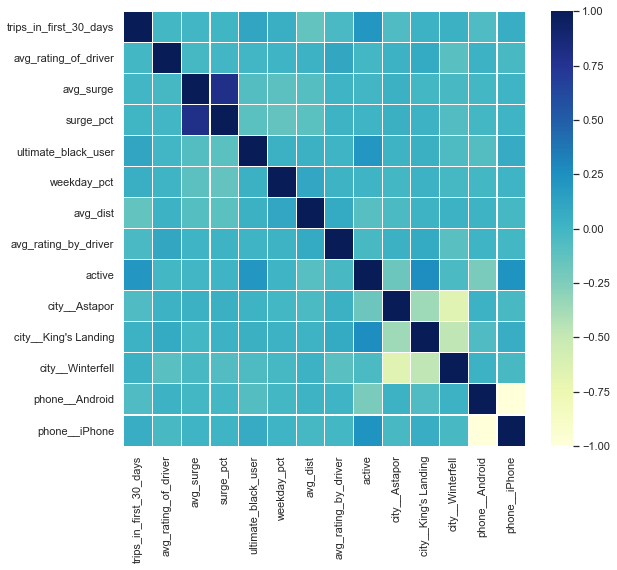

In [38]:
#let's look at the correlation among the features
corrmat = df.corr()
  
fig, ax = plt.subplots(figsize =(9, 8))
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

**The heatmap shows little correlation among the features save for avg_surge and surge percent. This may indicate that one may not contribute much to the predictive model. More information about the max and min surge may be helpful**

(array([30771.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 18635.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

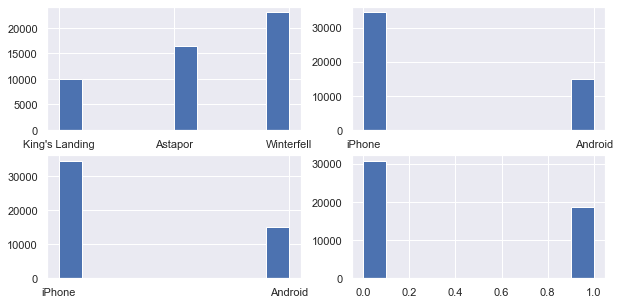

In [39]:
#Examine the distribution of the categorical variables
plt.figure(figsize = [10, 5]) # larger figure size for subplots

# city
plt.subplot(2, 2, 1) 
plt.hist(data = udc_df, x = 'city')

# phone
plt.subplot(2, 2, 2) 
plt.hist(data = udc_df, x = 'phone')

#ultimate black user
plt.subplot(2, 2, 3) 
plt.hist(data = udc_df, x = 'phone')

#active
plt.subplot(2, 2, 4)
plt.hist(data = udc_df, x = 'active')

In [40]:
print("The percent of active users is: {:.1f}".format(udc_df['active'].sum()/len(udc_df)))

The percent of active users is: 0.4


**The categorical variables do not appear to be particularly skewed**


## Modeling <a name='model'>

A random forest model is used because of its efficiency and accuracy. An initial model is generated and then some hyperparameter tuning is performed.

In [64]:
#import packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score,  recall_score
from sklearn.preprocessing import StandardScaler



### Additional Preprocessing <a name = "preprocess">

In [43]:
#Separate features and labels
features = ['trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'ultimate_black_user','weekday_pct', 'avg_dist', 'avg_rating_by_driver', 'city__Astapor', "city__King's Landing", 'city__Winterfell', 'phone__Android', 'phone__iPhone' ]
X = df[features]
y = df['active']

In [48]:
#separate training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, stratify = y, random_state = 1)

In [49]:
#Scale the features
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### Initial model <a name="initial">

In [50]:
rf = RandomForestClassifier(n_estimators = 200, min_samples_leaf = 0.12, random_state = 1)

rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=0.12, n_estimators=200, random_state=1)

In [51]:
y_pred = rf.predict(X_test)


In [52]:
y_pred

array([0, 0, 0, ..., 0, 1, 0], dtype=uint8)

In [53]:
accuracy_score(y_test, y_pred)

0.7078526614045739

In [74]:
precision_score(y_test, y_pred)

0.7258064516129032

In [75]:
recall_score(y_test, y_pred)

0.36222162597263213

The initial model shows promise with a 70% accuracy. It is better than a default of labeling all as "not active" which would give 60% accuracy


### Hyperparameter Tuning <a name="tuning">

In [54]:
from sklearn.model_selection import GridSearchCV

rf_cv = RandomForestClassifier()

params = {'n_estimators': [100, 250, 400], 'max_features' : ['auto', 'sqrt', 'log2'], 'min_samples_leaf': [1, 100, 1000]}

grid_rf = GridSearchCV(estimator = rf_cv, param_grid = params, scoring = 'accuracy', cv = 5, verbose = 2)

In [55]:
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] max_features=auto, min_samples_leaf=1, n_estimators=100 .........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=auto, min_samples_leaf=1, n_estimators=100, total=   6.3s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=100 .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.2s remaining:    0.0s


[CV]  max_features=auto, min_samples_leaf=1, n_estimators=100, total=   7.2s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=100 .........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=100, total=   6.2s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=100 .........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=100, total=   6.4s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=100 .........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=100, total=   6.6s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=250 .........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=250, total=  16.6s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=250 .........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=250, total=  16.6s
[CV] max_features=auto, min_samples_leaf=1, n_estimators=250 .........
[CV]  max_features=auto, min_samples_leaf=1, n_estimators=250, total=  16.3s
[CV] max_features=auto, min_samples

[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=400, total=  24.3s
[CV] max_features=sqrt, min_samples_leaf=1, n_estimators=400 .........
[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=400, total=  27.6s
[CV] max_features=sqrt, min_samples_leaf=1, n_estimators=400 .........
[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=400, total=  27.0s
[CV] max_features=sqrt, min_samples_leaf=1, n_estimators=400 .........
[CV]  max_features=sqrt, min_samples_leaf=1, n_estimators=400, total=  24.2s
[CV] max_features=sqrt, min_samples_leaf=100, n_estimators=100 .......
[CV]  max_features=sqrt, min_samples_leaf=100, n_estimators=100, total=   3.3s
[CV] max_features=sqrt, min_samples_leaf=100, n_estimators=100 .......
[CV]  max_features=sqrt, min_samples_leaf=100, n_estimators=100, total=   3.5s
[CV] max_features=sqrt, min_samples_leaf=100, n_estimators=100 .......
[CV]  max_features=sqrt, min_samples_leaf=100, n_estimators=100, total=   3.4s
[CV] max_features=sqrt, min_s

[CV]  max_features=log2, min_samples_leaf=100, n_estimators=250, total=   8.1s
[CV] max_features=log2, min_samples_leaf=100, n_estimators=250 .......
[CV]  max_features=log2, min_samples_leaf=100, n_estimators=250, total=   8.6s
[CV] max_features=log2, min_samples_leaf=100, n_estimators=250 .......
[CV]  max_features=log2, min_samples_leaf=100, n_estimators=250, total=   7.9s
[CV] max_features=log2, min_samples_leaf=100, n_estimators=250 .......
[CV]  max_features=log2, min_samples_leaf=100, n_estimators=250, total=   8.5s
[CV] max_features=log2, min_samples_leaf=100, n_estimators=400 .......
[CV]  max_features=log2, min_samples_leaf=100, n_estimators=400, total=  13.2s
[CV] max_features=log2, min_samples_leaf=100, n_estimators=400 .......
[CV]  max_features=log2, min_samples_leaf=100, n_estimators=400, total=  13.3s
[CV] max_features=log2, min_samples_leaf=100, n_estimators=400 .......
[CV]  max_features=log2, min_samples_leaf=100, n_estimators=400, total=  12.6s
[CV] max_features=log

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed: 23.0min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 100, 1000],
                         'n_estimators': [100, 250, 400]},
             scoring='accuracy', verbose=2)

In [56]:
grid_rf.best_params_

{'max_features': 'log2', 'min_samples_leaf': 100, 'n_estimators': 100}

In [57]:
best_model = RandomForestClassifier(n_estimators = 100, min_samples_leaf = 1, max_features = 'log2')

In [59]:
best_model.fit(X_train, y_train)

RandomForestClassifier(max_features='log2')

In [61]:
preds = best_model.predict(X_test)
accuracy_score(y_test, preds)

0.756729407002631

In [63]:
confusion_matrix(y_test, preds)

array([[5036, 1119],
       [1285, 2442]], dtype=int64)

In [65]:
precision_score(y_test, preds)

0.6857624262847515

In [66]:
recall_score(y_test, preds)

0.6552186745371612

In [67]:
#determine how important each feature is
importances = best_model.feature_importances_

# Sort the feature importance in descending order
sorted_indices = np.argsort(importances)[::-1]

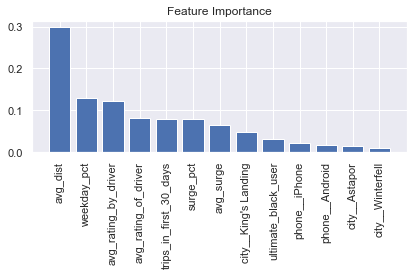

In [71]:
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()


### Summary and Recommendations <a name="recommend">

With minimal hyperparameter tuning, the model obtained a 75.7% accuracy and a marked increase in the recall score from the initial model. With additional time investment, further tuning can be performed and other models tried.

Using the model may allow Ultimate to target promotions toward riders that will likely be lost otherwise to increase retention. Additionally, focusing on increasing the occurance of the more important features may help. For example, offer a discount for rides over a certain distance to increase average distance traveled.